### Diving into the data

First we load up the data into a Pandas DataFrame and get a very high-level overview.

In [1]:
import pandas as pd

requests = pd.DataFrame.from_csv("311.csv.gz")
requests.describe()

,creation_date,Borough,Nature
count,1249761,1249761,1249761
unique,1826,19,4397
top,2012-05-29,Saint-Laurent,Chien - Permis
freq,1952,142198,61138


### Time and Space

We seem to have 1826 days or 5 years of data across all 19 of Montreal's boroughs, so let's make a quick chart of request counts over time by borough. Daily is too fine a grain so we'll go monthly. 

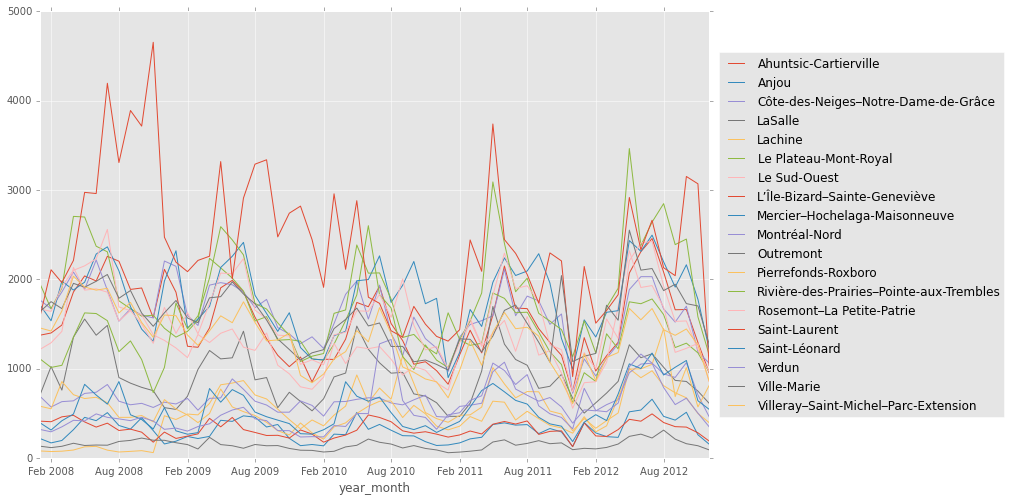

In [2]:
from datetime import date

requests.creation_date = pd.to_datetime(requests.creation_date)
requests["year_month"] = requests.creation_date.apply(
    lambda x: date(year=x.year, month=x.month, day=1)
)
requests["Year"] = requests.creation_date.apply(lambda x: x.year)
requests["Month"] = requests.creation_date.apply(lambda x: x.strftime("%b"))

%matplotlib inline
from matplotlib import rcParams, style
style.use('ggplot')
rcParams['figure.figsize'] = 12, 8

requests.pivot_table(
    index='year_month', columns='Borough', 
    values='Nature', aggfunc=len
).plot().legend(loc='center right', bbox_to_anchor=(1.45, 0.5))

This is not a particularly readable chart, but it certainly looks like we have data from every borough for every month. There appear to be some major inter-borough differences (Saint-Laurent is the only the 8th most populous borough but has by far the most requests) as well as temporal patterns (a yearly pattern of low-winter/high-summer). The idea behind this analysis is to get a handle on these differences.

----------------

### The Nature of Things

Let's take a look at that `Nature` column; it seems to have too many different values to easily make sense of.

In [3]:
nature_counts = requests.Nature.value_counts().reset_index(name="counts")
nature_counts

,index,counts
0,Chien - Permis,61138
1,Déchets - Objet volumineux à ramasser,54913
2,Éclairage existant - Entretien,52255
3,Environnement - Bac ou sac de récupération - D...,44306
4,Déchets - Collecte,44141
5,Déchets - Dépôt illégal,43487
6,Arbre - Élagage,31731
7,Feux de circulation - Entretien,30841
8,Environnement - Collecte sélective,29808
9,Intervention stationnement,29550


And now graphically:

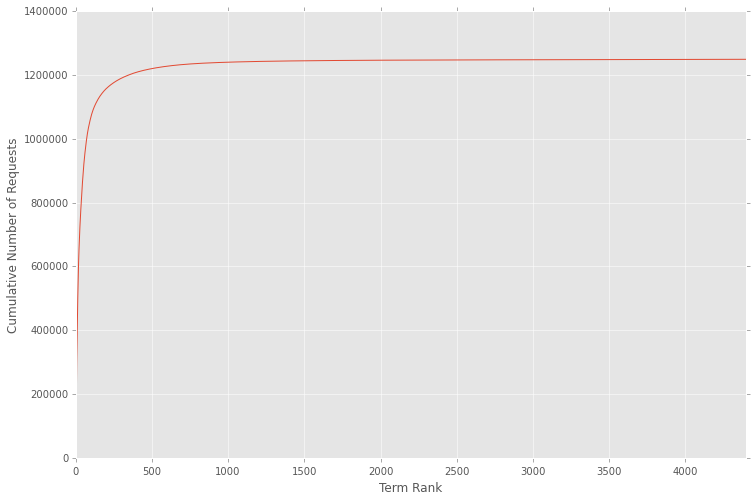

In [4]:
p = nature_counts.cumsum().plot(legend=False)
p.set_xlabel("Term Rank")
p.set_ylabel("Cumulative Number of Requests")

------------

### Cardinality Reduction

In order to get a better sense of the temporal and spatial patterns of this data by digging into the kinds of requests we have in this dataset, we'll need to group the 4000+ values of the `Nature` column into a smaller number of categories. A manageable number would be between 10 and 20 categories, including a catch-all "Other" which should not be the biggest, and where there is less than a 10-to-1 difference in size between the biggest and the smallest categories.

The general approach we'll take is to group the requests based on keywords present in the `Nature` field. We'll start with some basic prep on the data by normalizing it all to ASCII. This isn't strictly necessary but makes it easier to write string-matching code without having to type accents on a standard US keyboard. It will also help with string-matching in case a french word was mistyped without accents (admittedly, not a particularly common occurrence).

In [5]:
import unicodedata

def to_ascii(input_str):
    if isinstance(input_str, str):
        input_str = input_str.decode('utf-8')
    elif not isinstance(input_str, unicode):
        input_str = str(input_str).decode('utf-8')
    nkfd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nkfd_form.encode('ASCII', 'ignore')
    return only_ascii

requests.Nature = requests.Nature.apply(to_ascii)

A fairly subjective iterative categorization process yields the following categorization function. The keys of the `keywords` dictionary are the category names and the values are the set of words which will cause that category to be applied to a given request if present in the `Nature` field. The first category to match is the one that is applied to the request.

The process used was to start with no filters (i.e. all requests are categorized as "Other") and then iterate through:
1. Generating a list of the most frequent values of `Nature` per category
1. Adding or modifying the list of filters based on the list above to move requests out of the "Other" category
1. Stopping if the categories meet the goals, otherwise iterating again

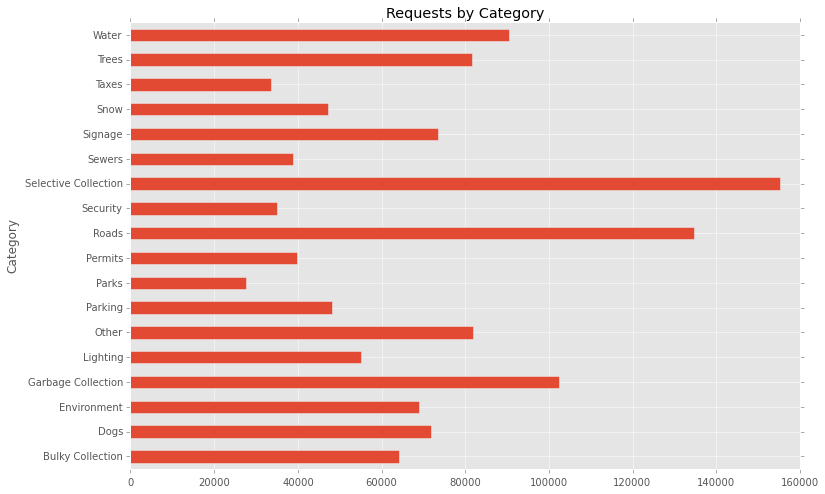

In [6]:
from collections import OrderedDict
import re

def categorize(x):
    keywords = OrderedDict()
    keywords["Dogs"] = ["chien"]
    keywords["Taxes"] = ["changement d'adresse", "taxes", "taxe"]
    keywords["Permits"] = ["permis", "occupation","zonage"]
    keywords["Selective Collection"] = ["bac","bacs","sac","sacs","recyclage","residus",
                                        "collecte selective","collecte de branches",
                                        "collecte de feuilles"]
    keywords["Bulky Collection"] = ["volumineux"]
    keywords["Garbage Collection"] = ["collecte","dechets"]
    keywords["Trees"] = ["arbre"]
    keywords["Water"] = ["eau"]
    keywords["Sewers"] = ["egout","puisard"]
    keywords["Signage"] = ["signalisation","marquage","feux"]
    keywords["Snow"] = ["neige","deneigement"]
    keywords["Roads"] = ["voirie","voie","travaux","rue","chaussee","charretiere","trottoir"]
    keywords["Environment"] = ["environnement","maisons fleuries","horticulture","pesticide",
                               "compost","animal", "punaises", "jardins","extermination",
                               "animaux","sauvage","gazon","bruit","nuisances"]
    keywords["Parking"] = ["stationnement","ads","srrr","parcometre"]
    keywords["Lighting"] = ["eclairage","lampadaire"]
    keywords["Parks"] = ["parc", "parcs", "chalet", "chalets","sport","sports","piscine"]
    keywords["Security"] = ["surveillance", "police", "securite"]

    keyword_res = OrderedDict() 
    for k in keywords:
        pat = "\\b%s\\b" % "\\b|\\b".join(keywords[k])
        keyword_res[k] = re.compile(pat, re.IGNORECASE)

    for r in keyword_res:
        if keyword_res[r].search(x): return r
    return "Other"

requests["Category"] = requests.Nature.map( 
    {x: categorize(x) for x in requests.Nature.unique()}.get 
)
requests.groupby("Category").size().plot(kind="barh", title="Requests by Category")

A cursory glance at the list reveals that it is close to being a mutually-exclusive, collectively-exhaustive (MECE) description of the service areas the city is involved in. This intuitively makes sense: any citizen request about anything else wouldn't be recorded in this dataset and it would be very surprising if the city offered a service that few people inquired or complained about. 

Of special note are the three "Collection" fields: waste collection requests were split up into three separate categories to avoid having one huge "Waste Collection" category. "Selective" collection covers recycling, branches etc and "Bulky" collection covers large waste items such as mattresses, furniture etc and "Garbage" is everything else.

So what kinds of requests ended up in each category? Here's a list of the top 5 values of `Nature` per category. 

In [7]:
x = requests.groupby(["Category", "Nature"]).size().reset_index(name="counts")\
    .sort(columns=["Category", "counts"], ascending=False)
x["grouprank"] = x.groupby(["Category"])['counts'].rank(ascending=False)
x.groupby(["Category"]).head(5).pivot_table(
    index="Category", columns="grouprank", values="Nature", aggfunc=lambda x:x)

grouprank,1.0,2.0,3.0,4.0,5.0
Category,,,,,
Bulky Collection,Dechets - Objet volumineux a ramasser,Dechets - Objet volumineux non ramasse,Dechets - Objet volumineux a,Dechets - Objet volumineux non,Dechets - Objet volumineux non ramass
Dogs,Chien - Permis,Chien - Fourriere et patrouille,*Chien sans permis,Chien - Fourriere et,Chien qui aboie
Environment,Environnement - Terrain insalubre,Environnement - Graffitis - Propriete privee,Environnement - Divers,Maisons fleuries,Environnement - Animal : pollution et nourriture
Garbage Collection,Dechets - Collecte,Dechets - Depot illegal,Environnement - Collecte d'ecran (ordinateur e...,*Dechets robotises - Non ramasses,*Autre - Dechets robotises
Lighting,Eclairage existant - Entretien,Lampadaire - Reparation,Eclairage - Etudes,Autre - Eclairage existant - Entretien,Eclairage insuffisant
Other,Subvention - Habitation,Reclamation,UIR - Utilite publique,Retour DDS,Services Techniques - Varia
Parking,Intervention stationnement,Intervention constat d'infraction SRRR,SRRR,Intervention de stationnement - Enquete,Agent de stationnement - Plainte contre un ADS
Parks,Parc - Varia,Parc - Proprete,Parc - Mobilier,"15 - Expulsion chalets, parcs, stationnements",Sports et loisirs - Installations
Permits,Permis - Divers,Permis - Logement,Permis - Construction,Permis - Bruit,Occupation du domaine public


We can also look how many different values of `Nature` ended up in each category, and see that things make sense: a big variety in the "Other" category and a fair number of different values collapsed into the various specific categories, roughly in proportion to how many requests fall in each category.

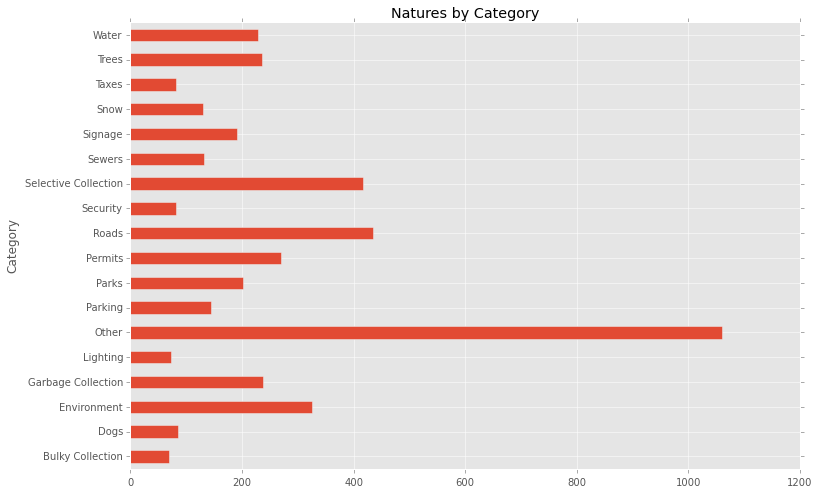

In [8]:
requests.groupby(["Category", "Nature"]).size().reset_index(name="counts")\
    .groupby("Category").size().plot(kind="barh", title="Natures by Category")

### Next Steps

We now have our categorized data, ready for some more interactive analysis using [PivotTable.js](https://github.com/nicolaskruchten/pivottable), an in-browser interactive pivot table tool. We'll export the data to a CSV to load into the pivot table. 

In [9]:
requests.groupby([
"Year", "Month", "Borough", "Category"
]).size().reset_index(name="Requests").to_csv("311_pivot.csv", index=False)

You can follow along with the rest of the analysis here: [Montreal 311 Service Requests, an Analysis](http://nicolas.kruchten.com/mtl311)